<a href="https://colab.research.google.com/github/rodrigoramiro/rodrigoramiro.github.io/blob/master/previsao_de_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Churn 

O Churn (rotatividade ou não-retenção)  de clientes, também conhecido como atrito de clientes, ocorre quando os clientes param de fazer negócios com uma empresa. As empresas estão interessadas em identificar segmentos desses clientes porque o preço para adquirir um novo cliente é geralmente mais alto do que reter o antigo. Por exemplo, se a Netflix conhecesse um segmento de clientes que corria o risco de abandono, eles poderiam envolvê-los proativamente com ofertas especiais, em vez de simplesmente perdê-los.

## Bibliotecas

In [ ]:
import platform
import pandas as pd
import sklearn
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
print('=== inventário das versões ===')
print('python version', platform.python_version())
print('pandas version', pd.__version__)
print('sklearn version', sklearn.__version__)
print('numpy version', np.__version__)
print('graphviz version', graphviz.__version__)
print('matplotlib version', matplotlib.__version__)

=== inventário das versões ===
python version 3.6.9
pandas version 1.1.2
sklearn version 0.22.2.post1
numpy version 1.18.5
graphviz version 0.10.1
matplotlib version 3.2.2


## Prepração do Dataset

Usamos o pandas para ler o conjunto de dados e pré-processá-lo. O conjunto de dados Telco tem um cliente por linha com muitas colunas (recursos).
Não há nenhuma linha com todos os valores ausentes ou duplicados (isso raramente acontece com conjuntos de dados do mundo real).
Caso existam amostras com TotalCharges definido como "", por exemplo, seria um erro nos dados. Removemos essas amostras e definimos o tipo como numérico (flutuante).

In [ ]:
#Derive the id from the google drive shareable link.
#For the file at hand the link is as below
#url2 = 'http://meusite.mackenzie.br/rogerio/telco-churn-2.csv'
#url1 = 'http://meusite.mackenzie.br/rogerio/telco-churn-new.csv'
#df = pd.read_pickle(url1)
#df = pd.read_csv(url1)
#df.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/telco-churn-new.csv')

df.shape

(1407, 20)

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,3192-LNKRK,Male,0,Yes,Yes,34,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Mailed check,84.05,2909.95
1,8285-ABVLB,Female,0,Yes,No,70,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.85,1328.35
2,6651-AZVTJ,Male,0,Yes,Yes,49,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.80,4872.45
3,0080-EMYVY,Female,0,No,No,14,Yes,No,DSL,No,Yes,No,No,No,No,One year,No,Credit card (automatic),51.45,727.85
4,3244-CQPHU,Female,1,No,No,72,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.10,7746.70


In [ ]:
df = df.dropna(how="all")  # remove samples with all missing values
df.shape

(1407, 20)

In [ ]:
df = df[~df.duplicated()] # remove duplicates
df.shape

(1407, 20)

In [ ]:
total_charges_filter = df.TotalCharges == " "
df = df[~total_charges_filter]
df.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(1407, 20)

In [ ]:
df.TotalCharges = pd.to_numeric(df.TotalCharges)

## Análise exploratória dos dados
Temos 2 tipos de recursos no conjunto de dados: categóricos (dois ou mais valores e sem qualquer ordem) e numéricos. A maioria dos nomes de recursos são autoexplicativos, exceto por:

- Parceiro: se o cliente tem um parceiro ou não (Sim, Não),
- Dependentes: se o cliente tem dependentes ou não (Sim, Não),
- Backup online: se o cliente tem backup online ou não (Sim, Não, Sem serviço de internet),
mandato: número de meses que o cliente permaneceu na empresa,
- Mensalidades: o valor cobrado do cliente mensalmente,
- TotalCharges: valor total cobrado do cliente.
- Caso existem clientes e recursos  no conjunto de dados sem customerID (não informativo) e coluna Churn (variável de destino). A maioria dos recursos categóricos tem 4 ou menos valores exclusivos.


In [ ]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,1407,1407,1407.000000,1407,1407,1407.000000,1407,1407,1407,1407,1407,1407,1407,1407,1407,1407,1407,1407,1407.000000,1407.000000
unique,1407,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN
top,8226-BXGES,Female,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,722,NaN,749,973,NaN,1287,692,629,705,621,626,659,547,567,770,804,465,NaN,NaN
mean,NaN,NaN,0.154940,NaN,NaN,32.152807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.655259,2272.573099
std,NaN,NaN,0.361976,NaN,NaN,24.331023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.349984,2280.847658
min,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.550000,19.100000
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,389.025000
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.700000,1387.000000
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.450000,3660.425000


We combine features into two lists so that we can analyze them jointly. 

In [ ]:
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
target = "Churn"

### Feature distribution

We plot distributions for numerical and categorical features to check for outliers and compare feature distributions with target variable.

#### Numerical features distribution

Numeric summarizing techniques (mean, standard deviation, etc.) don't show us spikes, shapes of distributions and it is hard to observe outliers with it. That is the reason we use histograms.

In [ ]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,1407.000000,1407.000000,1407.000000
mean,32.152807,64.655259,2272.573099
std,24.331023,30.349984,2280.847658
min,1.000000,18.550000,19.100000
25%,9.000000,35.000000,389.025000
50%,29.000000,70.700000,1387.000000
75%,56.000000,89.450000,3660.425000
max,72.000000,118.750000,8672.450000


À primeira vista, não há outliers nos dados. Nenhum ponto de dados está desconectado da distribuição ou muito longe do valor médio. Para confirmar que precisaríamos calcular o intervalo interquartil ([IQR](https://www.purplemath.com/modules/boxwhisk3.htm)) e mostrar que os valores de cada característica numérica estão dentro do IQR 1,5 do primeiro e terceiro quartil.

Poderíamos converter recursos numéricos em intervalos ordinais. Por exemplo, a posse é numérica, mas frequentemente não nos importamos com pequenas diferenças numéricas e, em vez disso, agrupamos a posse para clientes com mandato de curto, médio e longo prazo. Uma razão para convertê-lo seria reduzir o ruído, muitas vezes pequenas flutuações são apenas ruído.

In [ ]:
df[numerical_features].describe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe611ddb470>,
      dtype=object)

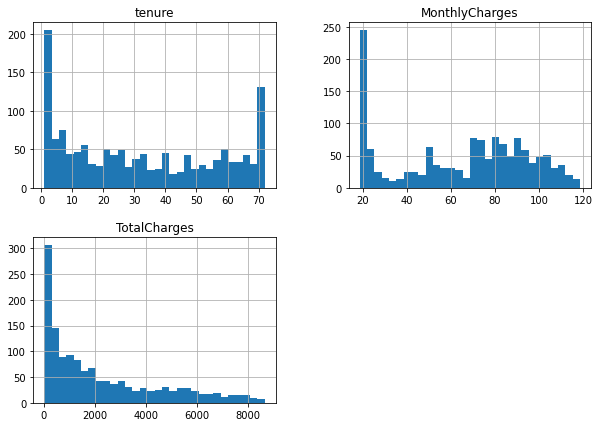

In [ ]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

Vemos as distribuições de recursos numéricos em relação à variável de destino. Podemos observar que quanto maiores os TotalCharges e a posse, menor é a probabilidade de rotatividade.

In [ ]:
df[target].describe()

KeyError: ignored

AttributeError: ignored

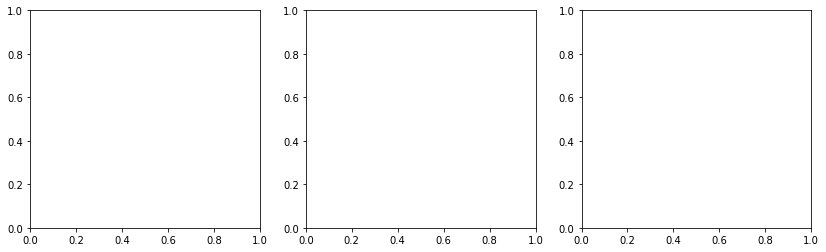

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

#### Distribuição das características por categorias



Para analisar características categóricas, usamos gráficos de barras. Observamos que a terceira idade e clientes sem serviço telefônico estão menos representados nos dados.

TypeError: ignored

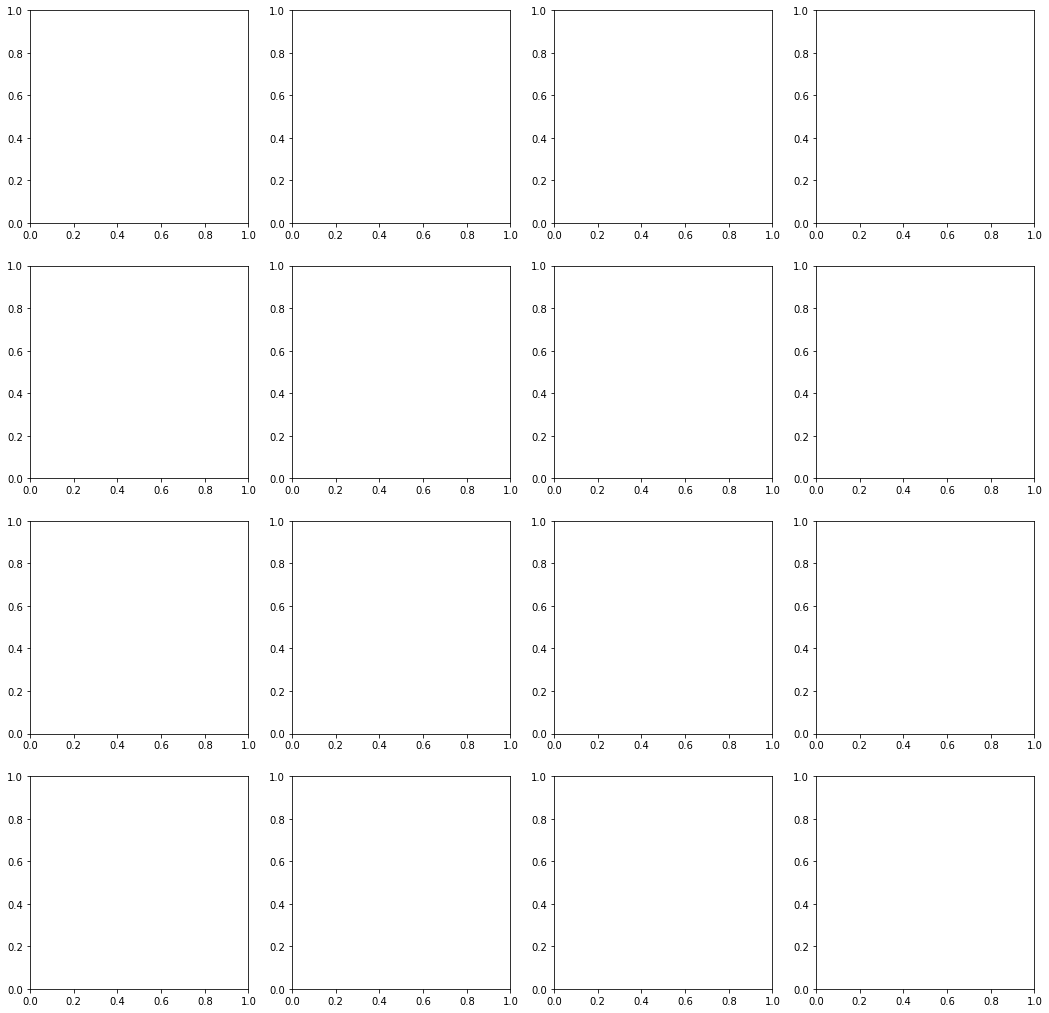

In [ ]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)

A próxima etapa é examinar os recursos categóricos em relação à variável de destino. Fazemos isso apenas para o recurso de contrato. Os usuários que têm um contrato mensal são mais propensos a se desligar do que os usuários com contratos de longo prazo.

Text(0.5,1,'churned')

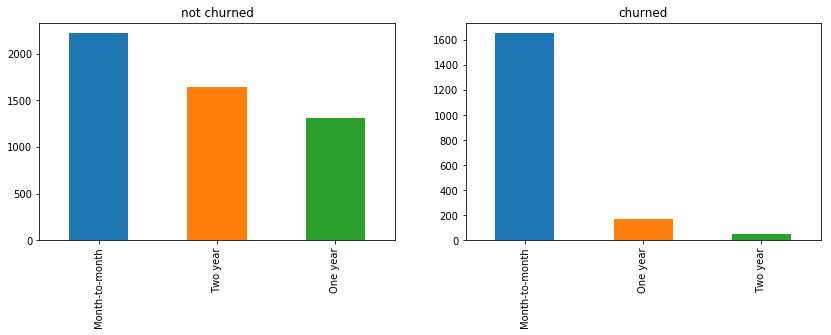

In [ ]:
feature = 'Contract'
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.Churn == "No"][feature].value_counts().plot('bar', ax=ax[0]).set_title('not churned')
df[df.Churn == "Yes"][feature].value_counts().plot('bar', ax=ax[1]).set_title('churned')

#### Distribuição da variável alvo

A distribuição da variável target mostra que estamos lidando com um problema desequilibrado, pois há muitos mais usuários não rotativos como rotativos. O modelo alcançaria alta precisão, pois previa principalmente a classe majoritária - usuários que não se desligaram em nosso exemplo.

Poucas coisas podemos fazer para minimizar a influência do conjunto de dados desequilibrado:
- dados de reamostragem (https://imbalanced-learn.readthedocs.io/en/stable/),
- coletar mais amostras,
- use precisão e recall como métricas de precisão.

In [ ]:
print(df[target].value_counts())
df[target].value_counts().plot('bar').set_title('churned')

NameError: ignored

## Recursos

O conjunto de dados Telco já está agrupado por customerID, por isso é difícil adicionar novos recursos. Ao trabalhar na previsão de churn, geralmente obtemos um conjunto de dados que tem uma entrada por sessão do cliente (atividade do cliente em um determinado momento). Então, poderíamos adicionar recursos como:
  - número de sessões antes de comprar algo,
  - tempo médio por sessão,
  - diferença de tempo entre as sessões (cliente frequente ou menos frequente),
  - é um cliente apenas em um país.

Às vezes, temos até dados de eventos do cliente, o que nos permite encontrar padrões de comportamento do cliente em relação ao resultado (rotatividade).

### Codificação

Para preparar o conjunto de dados para modelagem de rotatividade, precisamos codificar recursos categóricos em números. Isso significa codificar "Sim", "Não" em 0 e 1 para que o algoritmo possa trabalhar com os dados. Este processo é chamado [onehot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}
for categorical in categorical_features + [target]:
    label_encoders[categorical] = LabelEncoder()
    df[categorical] = label_encoders[categorical].fit_transform(df[categorical])
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder gender - values: ['Female', 'Male']
Label encoder SeniorCitizen - values: [0, 1]
Label encoder Partner - values: ['No', 'Yes']
Label encoder Dependents - values: ['No', 'Yes']
Label encoder PhoneService - values: ['No', 'Yes']
Label encoder MultipleLines - values: ['No', 'No phone service', 'Yes']
Label encoder InternetService - values: ['DSL', 'Fiber optic', 'No']
Label encoder OnlineSecurity - values: ['No', 'No internet service', 'Yes']
Label encoder OnlineBackup - values: ['No', 'No internet service', 'Yes']
Label encoder DeviceProtection - values: ['No', 'No internet service', 'Yes']
Label encoder TechSupport - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingTV - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingMovies - values: ['No', 'No internet service', 'Yes']
Label encoder Contract - values: ['Month-to-month', 'One year', 'Two year']
Label encoder PaperlessBilling - values: ['No', 'Yes']
Label encoder PaymentMethod - values

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


## O Classifier

Usamos sklearn, uma biblioteca de aprendizado de máquina em Python, para criar um classificador.
A maneira sklearn é usar pipelines que definem o processamento de recursos e o classificador. Em nosso exemplo, o pipeline pega um conjunto de dados na entrada, pré-processa recursos e treina o classificador.
Quando treinado, ele recebe a mesma entrada e retorna previsões na saída.

No pipeline, processamos separadamente recursos categóricos e numéricos. Codificamos recursos categóricos e escalamos recursos numéricos removendo a média e escalonando-os para a variância unitária.
Escolhemos um modelo de árvore de decisão devido à sua interpretabilidade e definimos a profundidade máxima como 3 (arbitrariamente).

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

In [ ]:
pipeline = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                transformer_list=[
                    (
                        "categorical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=categorical_features)),
                                ("onehot", OneHotEncoder()),
                            ]
                        ),
                    )
                ]
                + [
                    (
                        "numerical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=numerical_features)),
                                ("scalar", StandardScaler()),
                            ]
                        ),
                    )
                ]
            ),
        ),
        ("classifier", tree.DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]
)

### Treinando o modelo

Dividimos o conjunto de dados para treinar (75% das amostras) e testar (25% das amostras).
Treinamos (ajustamos) o pipeline e fazemos previsões.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

pipeline.fit(df_train, df_train[target])
pred = pipeline.predict(df_test)

### Testando o modelo

Com a classificação_report, calculamos a precisão e a recuperação com os valores reais e previstos.
Para a classe 1 (usuários agitados), o modelo atinge precisão de 0,67 e recall de 0,37.
A precisão nos diz quantos usuários rotativos nosso classificador previu corretamente. Por outro lado, lembre-se de nos dizer quantos usuários rotativos ele perdeu. Em termos leigos, o classificador não é muito preciso para usuários rotativos.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_test[target], pred))

             precision    recall  f1-score   support

          0       0.81      0.94      0.87      1300
          1       0.67      0.37      0.48       458

avg / total       0.77      0.79      0.77      1758



## Interpretabilidade do modelo

O modelo de árvore de decisão usa os recursos de Contrato, MensalidadeCharges, InternetService, TotalCharges e posse para tomar uma decisão se um cliente se desligará ou não. Esses recursos separam bem os clientes cancelados de outros com base nos critérios de divisão na árvore de decisão.

Cada amostra do cliente atravessa a árvore e o nó final fornece a previsão.
Por exemplo, se Contract_Month-to-month for:
  - igual a 0, continue percorrendo a árvore com ramo verdadeiro,
  - igual a 1, continue atravessando a árvore com galho falso,
  - não definido, ele produz a classe 0.
 
Essa é uma ótima abordagem para ver como o modelo está tomando uma decisão ou se algum recurso inserido em nosso modelo que não deveria estar lá.

In [ ]:
dot_data = tree.export_graphviz(pipeline.named_steps['classifier'], out_file=None, 
                         feature_names = categorical_feature_names + numerical_features,
                         class_names=[str(el) for el in pipeline.named_steps.classifier.classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph